# Fuel Siphonage Detection Task

## Task Description
- Build a Python pipeline to detect fuel siphonage events based on telemetry logs.
- Siphonage is defined as a significant drop in fuel level while the vehicle engine is off and the vehicle is stationary.

In [ ]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from geopy.distance import geodesic

import warnings
warnings.filterwarnings('ignore')

In [375]:
#Loading the dataset

df = pd.read_csv('/content/sample_fuel_telemetry.csv')
df

,vehicle_id,timestamp,location_lat,location_lon,engine_status,fuel_level
0,V1,2025-03-25 08:00:00,1.2921,36.8219,ON,78
1,V1,2025-03-25 08:15:00,1.2921,36.8219,OFF,78
2,V1,2025-03-25 08:30:00,1.2921,36.8219,OFF,72
3,V1,2025-03-25 08:45:00,1.2921,36.8220,OFF,71
4,V1,2025-03-25 09:00:00,1.2922,36.8225,ON,69
5,V2,2025-03-25 08:00:00,-1.2921,36.8219,ON,90
6,V2,2025-03-25 08:10:00,-1.2921,36.8219,OFF,90
7,V2,2025-03-25 08:20:00,-1.2921,36.8219,OFF,85
8,V2,2025-03-25 08:30:00,-1.2921,36.8219,OFF,83


## Basic EDA

In [376]:
#Checking the shape of the data

df.shape

(9, 6)

- We have 9 rows and 6 columns

In [377]:
#Checking te datatype information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vehicle_id     9 non-null      object 
 1   timestamp      9 non-null      object 
 2   location_lat   9 non-null      float64
 3   location_lon   9 non-null      float64
 4   engine_status  9 non-null      object 
 5   fuel_level     9 non-null      int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 564.0+ bytes


In [378]:
#Converting the timestamp column to datetime for better analysis

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [379]:
df['timestamp'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9 entries, 0 to 8
Series name: timestamp
Non-Null Count  Dtype         
--------------  -----         
9 non-null      datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 204.0 bytes


- The column has been converted from object datatype to datetime datatype

## Visualizations

In [380]:
#Line chart to show fuel level over time (siphoning time is represented with a marker)

#Checking for siphoning times (siphoning will be considered when the engine is off, location remains the same yet there is a significant drop of fuel in the vehicle)

df.sort_values(by=['vehicle_id', 'timestamp'], inplace=True)

siphonage_period = []
threshold = 1

for i in range (1, len(df)):
  previous_row = df.iloc[i-1]
  current_row = df.iloc[i]

  if (
      current_row['vehicle_id'] == previous_row['vehicle_id'] and current_row['engine_status'] == 'OFF' and previous_row['engine_status'] == 'OFF'
      and current_row['location_lat'] == previous_row['location_lat'] and current_row['location_lon'] == previous_row['location_lon'] and
      previous_row['fuel_level'] - current_row['fuel_level'] >= threshold
  ):
    siphonage_period.append(current_row)

#Converting the siphon periods to a dataframe

siphon_period_df = pd.DataFrame(siphonage_period)
siphon_period_df

,vehicle_id,timestamp,location_lat,location_lon,engine_status,fuel_level
2,V1,2025-03-25 08:30:00,1.2921,36.8219,OFF,72
7,V2,2025-03-25 08:20:00,-1.2921,36.8219,OFF,85
8,V2,2025-03-25 08:30:00,-1.2921,36.8219,OFF,83


- The driver of vehicle 1 siphoned fuel at 8.30 am and driver of vehicle 2 at 8.20 am and 8.30 am, as there is seen to be a drop of fuel levels in both instances while the vehicles were not moving and their engines were off.

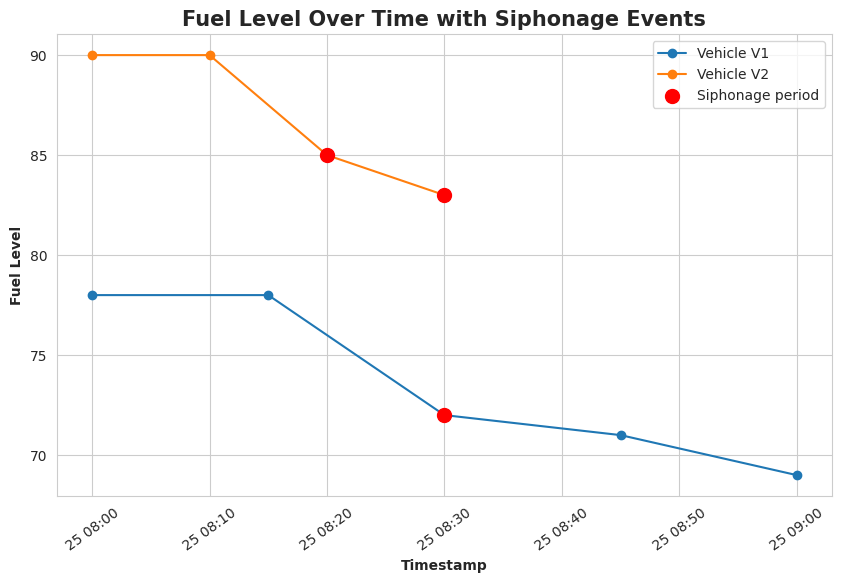

In [381]:
#Visualizing the periods of siphoning

plt.figure(figsize=(10,6))
sns.set_style('whitegrid')

# Plotting fuel levels over time
for vehicle in df['vehicle_id'].unique():
    vehicle_data = df[df['vehicle_id'] == vehicle]
    plt.plot(vehicle_data['timestamp'], vehicle_data['fuel_level'], label=f'Vehicle {vehicle}', marker='o')

# Plot siphonage periods
if not siphon_period_df.empty:
    plt.scatter(siphon_period_df['timestamp'], siphon_period_df['fuel_level'], color='red', label='Siphonage period', zorder=3, s=100)

plt.xlabel("Timestamp", weight = 'bold')
plt.ylabel("Fuel Level", weight = 'bold')
plt.title("Fuel Level Over Time with Siphonage Events", size = 15, weight = 'bold')
plt.legend(loc = 'best')
plt.xticks(rotation=36)
plt.show()

## Creating the siphonage column

In [382]:
# Convert timestamp column to datetime and sort values per vehicle
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['vehicle_id', 'timestamp'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Time difference in minutes between consecutive records per vehicle
df['time_diff'] = df.groupby('vehicle_id')['timestamp'].diff().dt.total_seconds() / 60
df['time_diff'].fillna(0, inplace=True)

# Fuel level drop from previous record (we assume drop is calculated as previous fuel - current fuel)
df['fuel_drop'] = df.groupby('vehicle_id')['fuel_level'].diff().fillna(0)

# Change in location (absolute differences in lat and lon)
df['lat_change'] = df.groupby('vehicle_id')['location_lat'].diff().abs().fillna(0)
df['lon_change'] = df.groupby('vehicle_id')['location_lon'].diff().abs().fillna(0)

df["prev_lat"] = df.groupby("vehicle_id")["location_lat"].shift(1)
df["prev_lon"] = df.groupby("vehicle_id")["location_lon"].shift(1)

# Checking movements of the vehicles
def check_movement(row, distance_threshold=0.01):
    if pd.isnull(row["prev_lat"]) or pd.isnull(row["prev_lon"]):
        return 0
    prev_coords = (row["prev_lat"], row["prev_lon"])
    current_coords = (row["location_lat"], row["location_lon"])
    distance = geodesic(prev_coords, current_coords).km
    return int(distance >= distance_threshold)

df["is_moving"] = df.apply(check_movement, axis=1)

#Removing the redundant columns
df.drop(columns=["prev_lat", "prev_lon"], inplace=True)

#Creating a siphonage column
df["siphonage"] = ((df["fuel_drop"] < 0) & (df["engine_status"] == "OFF") & (df["is_moving"] == 0)).astype(int)

#Removing values with no time difference
df = df[df['time_diff'] != 0].reset_index(drop=True)

#Encoding the engine status column
df['engine_status_flag'] = np.where(df['engine_status'] == 'ON', 1, 0)


In [ ]:
#Final dataframe that shows if siphonage occurred or not

df

,vehicle_id,timestamp,location_lat,location_lon,engine_status,fuel_level,time_diff,fuel_drop,lat_change,lon_change,is_moving,siphonage,engine_status_flag
0,V1,2025-03-25 08:15:00,1.2921,36.8219,OFF,78,15.0,0.0,0.0000,0.0000,0,0,0
1,V1,2025-03-25 08:30:00,1.2921,36.8219,OFF,72,15.0,-6.0,0.0000,0.0000,0,1,0
2,V1,2025-03-25 08:45:00,1.2921,36.8220,OFF,71,15.0,-1.0,0.0000,0.0001,1,0,0
3,V1,2025-03-25 09:00:00,1.2922,36.8225,ON,69,15.0,-2.0,0.0001,0.0005,1,0,1
4,V2,2025-03-25 08:10:00,-1.2921,36.8219,OFF,90,10.0,0.0,0.0000,0.0000,0,0,0
5,V2,2025-03-25 08:20:00,-1.2921,36.8219,OFF,85,10.0,-5.0,0.0000,0.0000,0,1,0
6,V2,2025-03-25 08:30:00,-1.2921,36.8219,OFF,83,10.0,-2.0,0.0000,0.0000,0,1,0
